# Report
## Vision
The goal for my project is to develop a neural network that can efficiently solve the wumpus world problem. This project would make me explore topics on reinforcement learning and Q-learning. The wumpus world problem is a game that is easy enough to code and be quickly simulated for fast training.

I want to create an agent that can learn how to play Wumpus World without any prior data or knowledge of the environment. If time allows, I would like to make the environment dynamic, such as having the Wumpus move around the board.

## Background
The Wumpus World is a game that requires an agent to navigate a 4x4 cave with limited senses. The objective is to grab the gold and exit the cave while dodging pits and the Wumpus. When researching models for solving such a problem, the [OpenAI Gym](https://openai.com/blog/openai-baselines-dqn/) was a common solution for modeling these environments and training such networks. OpenAI Gym focuses on reinforcement networks, and it has found the most success with a Deep Q Network (DQN). There are many variants of a DQN including Double Q Learning, Prioritized Replay, Dueling DQN. For simplicity, I focused on implementing a basic DQN rather than experimenting with the variants. 

DQNs are a new type of network structue that we have not previously explored in class. But it wasn't very hard to find a variety of articles on the subject. Starting from the source, OpenAI Gym states how difficult reinforcement learning (RL) can be because noisy performance can lead to many unreproducable results. But researchers at DeepMind found DQNs to provide the best performance in RL problems. 

Naturally, understanding how DQN works is an essential step in the process. One the better articles on the subject that I found was [Reinforcement Learning w/ Keras + OpenAI: DQNs](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c). This article provided a lot of high-level information and implementation on the subject that I could easily reproduce within my environment. This one sentence from the article is a great intro to the topic:

> "Q-learning (which doesn’t stand for anything, by the way) is centered around creating a “virtual table” that accounts for how much reward is assigned to each possible action given the current state of the environment."
 
Essentially, for any given situation or state of the world, there will be a table of values that map a theoretical Q-score to each action. In the [Reinforcement Learning (DQN) Tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html), PyTorch provides a good description of the DQN algorithm and training process. The first important aspect of DQN trainging is the replay memory. This collection of data stores the transitions that an agent observes (state -> action -> new state + reward). By randomly sampling from this memory, the DQN can use this data as a means for training. The DQN algorithm basically states that if we had a function $$Q* : State \times  Action \rightarrow R$$ that could tell us what our return would be, we could use that in any given state to predict which action we should take for maximizing score. Since this function doesn't exist, we train our network to resemble Q*. To minimise the error within the network, DQN uses a Huber loss on the temporal difference error on the function $$ \beta = Q(s, a) - (r + \gamma maxQ(s', a))$$ This error basically represents the difference between the predicted and target state values.

With the memory and training structures in place, we can begin to work with our model and its hyper parameters. The first step the model takes is acting. The exploratory or epsilon hyper parameter is the probability that the agent chooses a random action rather than the one predicted by the network. This allows the agent to explore the world early on so it can build memory with a variety of actions and consequences. Epsilon decay is another hyper parameter that decreases the epsilon over training so that the agent slowly starts to use its predicted actions more often. Once the action has been taking in the environment, the agent remembers the whole transition (state -> action -> new state + reward). Then is enters the replay training step. In this step, the agent uses the acculated memory to randomly sample transitions and predict their outcomes. Using the training algorithm previously discussed, the agent trains itself on its past experience. Depending on the complexity of the environment, this bootstrapping can either work quickly or slowly. The unique and cool feature of DQNs is that we don't necessarily need any previous training data, we simply generate it ourselves.

In the previously mentioned [Reinforcement Learning w/ Keras + OpenAI: DQNs](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c), the author uses two identical networks, one called the model and the other target model. The hyper parameter tau tells how quickly the target model moves towards the model. This technique appears to match the Double Q Learning model presented in the [OpenAI Gym](https://openai.com/blog/openai-baselines-dqn/) article. This technique basically corrects any overestimatations made by the model, retaining what has been learned in the target model. By setting the tau value to 1, we once again have a simple DQN model.

I also thought that an RNN network on top of a DQN could be an interesting solution to providing more memory in the system. From this research paper: [Deep Q-Learning with Recurrent Neural Networks](http://cs229.stanford.edu/proj2016/report/ChenYingLaird-DeepQLearningWithRecurrentNeuralNetwords-report.pdf), it seemed that this may be a possibility. But when doing more research on the topic, I would run into post like this: [How does LSTM in deep reinforcement learning differ from experience replay?](https://ai.stackexchange.com/questions/7721/how-does-lstm-in-deep-reinforcement-learning-differ-from-experience-replay), where the top answer basically said they don't work well together. Since the experience replay method randomly samples from past experiences, it doesn't work well in the RNN since the RNN would expected correlated samples.
## Implementation
I started implementing my system with the Wumpus World environment. I simply inherited from the OpenAI gym environment parent class and implemented all the necessary methods and logic for Wumpus World. One of the convenient aspects of Wumpus World is that it doesn't require any graphics or images. The inputs to the DQN are simply the observations specified within the textbook [Artifical Intelligence: A Modern Approach](http://aima.cs.berkeley.edu/), and the outputs are the list of actions as from the textbook as well. One thing that I did later change from the textbook was that I added the agents position, direction, gold status to the observations. It seems to greatly boost performance and didn't really compromise the problem since it is data that can be tracked in any other algorithm. 

In [30]:
import sys
import gym
from gym import spaces
import numpy as np
import random
from enum import IntEnum
import math

class Wumpus(gym.Env):
    metadata = {'render.modes': ['human']}   
    class Board(IntEnum):
        NOTHING = 0
        PIT = 1
        BREEZE = 2
        WUMPUS = 3
        STENCH = 4
        GOLD = 5
        PLAYER = 6
        EXIT = 7
        WALL = 8

    class Direction(IntEnum):
        UP = 0
        LEFT = 1
        DOWN = 2
        RIGHT = 3

    class Actions(IntEnum):
        FORWARD = 0
        TURNLEFT = 1
        TURNRIGHT = 2
        GRAB = 3
        SHOOT = 4
        CLIMB = 5

    class Rewards(IntEnum):
        EXIT = -500
        EXIT_GOLD = 1000
        DEATH = -1000
        GRAB_GOLD = 500
        KILL_WUMPUS = 100
        SHOT_ARROW = -10
        
    def __init__(self, width=4, height=4):
        self.w = width
        self.h = height
        self.player = {
            "position": 0,
            "direction": 0, 
            "arrow": True,
            "gold": False,
        }
        self.action = 0
        self.reward = 0
        self.observations = []
        self.action_space = spaces.Discrete(6)

        self.observation_space = spaces.Tuple((
            spaces.Discrete(2),
            spaces.Discrete(2),
            spaces.Discrete(2),
            spaces.Discrete(2),
            spaces.Discrete(2),
            spaces.Discrete(2),
            spaces.Discrete(self.w * self.h),
            spaces.Discrete(4),
            spaces.Discrete(2),
        ))
        self._generate()
    
    def step(self, action):
        assert self.action_space.contains(action)
        observations = [False] * 9
        done = False
        reward = -1
        # Handle the actions
        if action == self.Actions.FORWARD:
            position, bump = self._move_forward(self.player["position"], self.player["direction"], self.Board.PLAYER)
            observations[3] = bump
            self.player["position"] = position
        elif action == self.Actions.TURNLEFT:
            self.player["direction"] = self._turn_left(self.player["direction"])
        elif action == self.Actions.TURNRIGHT:
            self.player["direction"] = self._turn_right(self.player["direction"])
        elif action == self.Actions.GRAB:
            if self.Board.GOLD in self.board[self.player["position"]]:
                reward += self.Rewards.GRAB_GOLD
                self.player["gold"] = True
                self.board[self.player["position"]].remove(self.Board.GOLD)
        elif action == self.Actions.SHOOT:
            reward += self.Rewards.SHOT_ARROW
            hit_something = False
            arrow_position = self.player["position"]
            # Move the arrow forward until it hits wall or wumpus
            while not hit_something:
                position, bump = self._move_forward(arrow_position, self.player["direction"])
                hit_something = bump
                arrow_position = position
                if self.Board.WUMPUS in self.board[arrow_position]:
                    hit_something = True
                    observations[4] = True
                    # Remove the Wumpus and stench
                    self.board[arrow_position].remove(self.Board.WUMPUS)
                    for p in self._get_adjacent(arrow_position):
                        self.board[p].remove(self.Board.STENCH)
                    reward += self.Rewards.KILL_WUMPUS
            pass
        elif action == self.Actions.CLIMB:
            if self.Board.EXIT in self.board[self.player["position"]]:
                reward += self.Rewards.EXIT_GOLD if self.player["gold"] else self.Rewards.EXIT
                done = True

        # Check if the player died
        position = self.board[self.player["position"]]
        if self.Board.PIT in position or self.Board.WUMPUS in position:
            reward += self.Rewards.DEATH
            done = True
        observations = self._get_observations(observations)

        # Record things for rendering
        self.action = action
        self.reward = reward
        self.observations = observations
        
        return np.array(observations), reward, done, {}
            
    def reset(self):
        self.player = {
            "position": 0,
            "direction": 0,
            "arrow": True,
            "gold": False,
        }
        self._generate();
        return self._get_observations()

    
    def render(self, mode='human', close=False):
        out = sys.stdout
        for i in range(self.h):
            for j in range(self.w):
                #out.write("" + np.sum(list(self.board[i * self.h + j])).tostring())
                out.write("{} ".format(np.sum(list(self.board[i * self.h + j]))))
            out.write("\n")
        out.write("Action: {}, Reward: {}\n".format(self.action, self.reward))
        print(self.observations)
        for i in range(self.h + 2):
            sys.stdout.write("\033[F")

    def _get_observations(self, observations=[False] * 9):
        position = self.board[self.player["position"]]
        observations[0] = self.Board.STENCH in position
        observations[1] = self.Board.BREEZE in position
        observations[2] = self.Board.GOLD in position
        observations[5] = self.Board.EXIT in position
        observations[6] = self.player["position"]
        observations[7] = self.player["direction"]
        observations[8] = self.player["gold"]
        
        return observations

    def _move_forward(self, position, direction, item=None):
        new_position = position
        distance = self.h if direction % 2 == 0 else 1
        sign = -1 if direction < 2 else 1
        move_to = position + (distance * sign)
        new_position = move_to if self._valid_move(position, move_to) and self.Board.WALL not in self.board[move_to] else position
        if item is not None:
            self.board[position].discard(item)
            self.board[new_position].add(item)
        return new_position, position == new_position

    def _valid_move(self, old, new):
        old_row = math.floor(old/self.w)
        new_row = math.floor(new/self.w)
        diff = abs(old - new)
        if diff == 1:
            return old_row == new_row
        elif diff == self.w:
            return new_row >= 0 and new_row < self.h
        else:
            return False

    def _turn_left(self, direction):
        return (direction + 1) % 4

    def _turn_right(self, direction):
        return (direction - 1) % 4

    def _is_empty(self, position):
        p = self.board[position]
        return not (self.Board.PIT in p or self.Board.EXIT in p or self.Board.WALL in p or self.Board.PLAYER in p or self.Board.WUMPUS in p or self.Board.GOLD in p)

    def _random_empty_place(self, item=None):
        rand = random.randrange(len(self.board))
        for i in range(len(self.board)):
            p = (rand + i) % len(self.board)
            if self._is_empty(p):
                if item is not None:
                    self.board[p].add(item)
                return p 
        print("Failed to place item")
        return -1
                
    def _get_adjacent(self, position):
        adjacent = []
        for direction in range(4):
            distance = self.h if direction % 2 == 0 else 1
            sign = -1 if direction < 2 else 1
            move_to = position + (distance * sign)
            if self._valid_move(position, move_to):
                adjacent.append(move_to)
        return adjacent
            

    def _generate(self):
        self.board = [{0} for _ in range(self.h * self.w)]

        # Add the player and the exit
        start_position = 12
        self.board[start_position].add(self.Board.PLAYER)
        self.board[start_position].add(self.Board.EXIT)
        self.player["position"] = start_position

        # Add the Wumpus
        wumpus_position = self._random_empty_place()
        self.board[wumpus_position].add(self.Board.WUMPUS)
        for p in self._get_adjacent(wumpus_position):
            self.board[p].add(self.Board.STENCH)

        # Add the pits
        for i in range(len(self.board)):
            if random.uniform(0, 1) < 0.1:
                # Only add a whole if it is empty
                if (self._is_empty(i)):
                    self.board[i].add(self.Board.PIT)
                    for p in self._get_adjacent(i):
                        self.board[p].add(self.Board.BREEZE)
                    
        # Place the gold at a random spot
        self._random_empty_place(self.Board.GOLD)

Next I implemented the agent and training method. I used [Reinforcement Learning w/ Keras + OpenAI: DQNs](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c) as a structure for my DQN code and later added the Double Q Learning model from the article to see if it improved my performance. Throughout the process of creating the environment, I tried training on many different configurations such as exit and gold only to see how well the agent could learn those environments. I created a simple terminal rendering of the 4x4 grid that simply diplayed the board state numerically. This was for a debugging interface, not really a visual.

I took some other liberties as well with the project. One example is that I lowered the spawn probability of pits from 0.2 to 0.1. I my early iterations of training, the bot always died and didn't seem to learn much of the environment, opting to always exit the room immediately.

The rewards were another difficult aspect of implementing the environment. The basic rewards given in the textbook are probably the most optimal, but I would run into annoying behaviors where the agent would exit immediately to cut its losses of dying in a pit. I ended up adding two extra weights to Wumpus World. First is -500 reward for exiting the cave without the gold. Second, a 500 reward for grabbing the gold. Both these additional weights encourage the agent to explore the world. Third, a 100 reward for killing the Wumpus.

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
from collections import deque
from keras.models import Sequential
from keras import Input
from keras.layers import Dense
from keras.optimizers import Adam
from keras.losses import Huber
# https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c
class DQNAgent:
    def __init__(self, env, run):
        self.run = run
        self.history = []
        self.env     = env
        self.memory  = deque(maxlen=10000)
        
        self.gamma = 0.95
        if not run:
            self.epsilon = 1.0
            self.epsilon_min = 0.0001
        else:
            self.epsilon = 0.0
            self.epsilon_min = 0.0
        self.epsilon_decay = 0.999
        self.learning_rate = 0.006
        self.tau = 0.8
        self.batch_size = 30

        self.model        = self._create_model()
        self.target_model = self._create_model()
        print(self.model.summary())

    def _create_model(self):
        model   = Sequential()
        state_shape  = self.env.observation_space.__len__()
        model.add(Dense(24, input_dim=state_shape, activation="relu"))
        model.add(Dense(24, activation="relu"))
        model.add(Dense(self.env.action_space.n, activation="linear"))
        model.compile(loss=Huber(), optimizer=Adam(lr=self.learning_rate))
        return model

    def act(self, state):
        self.epsilon *= self.epsilon_decay
        self.epsilon = max(self.epsilon_min, self.epsilon)
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.model.predict(state)[0])

    def remember(self, state, action, reward, new_state, done):
        self.memory.append([state, action, reward, new_state, done])

    def replay(self):
        if len(self.memory) < self.batch_size or self.run: 
            return

        samples = random.sample(self.memory, self.batch_size)
        for sample in samples:
            state, action, reward, new_state, done = sample
            target = self.target_model.predict(state)
            if done:
                target[0][action] = reward
            else:
                Q_future = max(self.target_model.predict(new_state)[0])
                target[0][action] = reward + Q_future * self.gamma
            history = self.model.fit(state, target, epochs=1, verbose=0)
            self.history.append(history.history['loss'][0])
        self.target_train()

    def target_train(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)

    def graph(self):
        plt.plot(self.history)
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()
        
    def load(self, path):
        if os.path.exists(path):
            self.model.load_weights(path)
            self.target_model.load_weights(path)
        else:
            print("Found no existing weights:", path)

    def save(self, path):
        self.target_model.save_weights(path)

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 24)                240       
_________________________________________________________________
dense_100 (Dense)            (None, 24)                600       
_________________________________________________________________
dense_101 (Dense)            (None, 6)                 150       
Total params: 990
Trainable params: 990
Non-trainable params: 0
_________________________________________________________________
None
Running 100 episodes
Run: 1, exploration: 0.9636582956114175, score: 1503 : [7, 4, 8, 7, 6, 5]
Run: 2, exploration: 0.9502544225688344, score: -1014 : [2, 5, 1, 4, 0, 2]
Run: 3, exploration: 0.9493041681462656, score: -501 : [0, 0, 0, 0, 0, 1]
Run: 4, exploration: 0.9483548639781193, score: -501 : [0, 0, 0, 0, 0, 1]
Run: 5, exploration: 0.9436225637280606, score: -505 : [1, 1, 

Run: 97, exploration: 0.0001, score: -1190 : [26, 21, 56, 65, 0, 22]
Run: 98, exploration: 0.0001, score: -1102 : [34, 20, 11, 16, 0, 21]
Run: 99, exploration: 0.0001, score: -1006 : [1, 3, 0, 2, 0, 0]
Run: 100, exploration: 0.0001, score: -1001 : [1, 0, 0, 0, 0, 0]


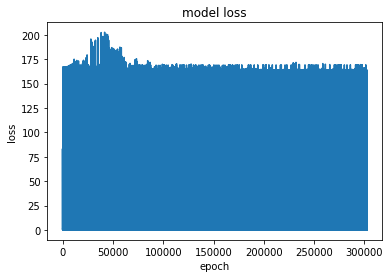

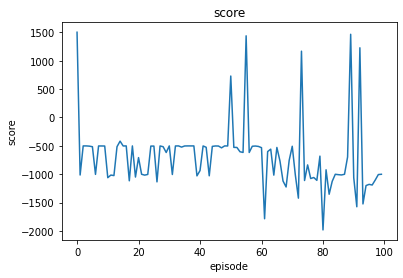

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import argparse
import re

parser = argparse.ArgumentParser()
parser.add_argument("-f", "--filename", help="The name of the model to load/save", default="model")
parser.add_argument("-r", "--run", help="Run a trained model", action="store_true")
parser.add_argument("-e", "--episodes", type=int, help="Number of episodes to run/train", default=100)
parser.add_argument("--maxsteps", type=int, help="The max steps in an episode. Prevents bot from looping", default=1000)
args = parser.parse_args()

weights_file = re.sub(r"\.h5$", "", args.filename) + ".h5"

def train():
    env = Wumpus() 
    observation_space = env.observation_space.__len__()
    action_space = env.action_space.n
    agent = DQNAgent(env, run=args.run)
    scores = []
    print("Running", args.episodes, "episodes")
    run = 0
    for _ in range(args.episodes):
        run += 1
        state = env.reset()
        state = np.reshape(state, [1, observation_space])
        score = 0
        step = 0
        action_count = [0] * env.action_space.n
        while True:
            step += 1
            # print("Step:",step)
            # env.render()
            action = agent.act(state)
            action_count[action] += 1
            state_next, reward, terminal, info = env.step(action)
            score += reward

            state_next = np.reshape(state_next, [1, observation_space])
            agent.remember(state, action, reward, state_next, terminal)
            state = state_next

            agent.replay()

            if terminal or step > args.maxsteps:
                print("Run: " + str(run) + ", exploration: " + str(agent.epsilon) + ", score: " + str(score) + " : " + str(action_count))
                scores.append(score)
                break
    agent.graph()
    plt.plot(scores)
    plt.title('score')
    plt.ylabel('score')
    plt.xlabel('episode')
    plt.show()

train()

## Results
For a majority of the project, the results were not too great. There often were a few emergent behaviors that often showed up. When there was no cap on the number of actions the agent could take, they would stay in one spot performing a useless action so that the game never ended. As mentioned before, another common behavior was to exit the cave immediately. When testing with just the exit and gold, the agent would run laps around the outer perimeter since that has a higher chance of gold. Most of the malignant behaviors were solved by adding the additional information of player position, direction, and gold status to the oberseved state. While this did feel a little bit like cheating, I think the amount of training I would have to do otherwise would be unreasonable. I wanted a system that I could iterate fast so that I could tune hyper parameters and see there effects without waiting for hours. However, it is the nature of the problems that you need to train the agent a lot and have a long exploring phase so that the agent can understand all the objectives in the game and their reward. Given the right conditions, my DQN agent could end up doing well near the end of the training, but often it would end poorly. With the new changes I actually began to see consistent runs that performed better than a random agent, which I will deem a success. The agent was usually not very efficient, but it seemed to understand the goal of "get the gold and exit." 

I wish I could have spent more time on this problem experimenting with different model structures, and I also wish I had implemented a Bayesian agent as a baseline performance measure for my DQN agent.

## Implications
I don't think are many social or ehtical implications within my specific project, but some things did cross my mind while working on the project. The main thing that I was thinking was how this problem could already be solved with a Bayesian algorithm, and it would probably work better too. I spent so much time and energy training this bot when I could have simply solved the problem in a more efficient manner. I even began to work on a Bayesian agent but ran out of time. The main takeaway for me was that if there are simpler methods that already do the job well, you mind as well use those instead. A lot of resources are poured into training neural networks, and from an ecological standpoint, it may not be the best use of resources.

## References
1. [OpenAI Gym](https://openai.com/blog/openai-baselines-dqn/)
2. [Reinforcement Learning w/ Keras + OpenAI: DQNs](https://towardsdatascience.com/reinforcement-learning-w-keras-openai-dqns-1eed3a5338c)
3. [Reinforcement Learning (DQN) Tutorial](https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html)
4. [Artifical Intelligence: A Modern Approach](http://aima.cs.berkeley.edu/)
5. [Deep Q-Learning with Recurrent Neural Networks](http://cs229.stanford.edu/proj2016/report/ChenYingLaird-DeepQLearningWithRecurrentNeuralNetwords-report.pdf)